In [21]:
%matplotlib inline
import numpy as np
import scipy
import pyttsx3
from scipy.io import wavfile
from scipy import fft
from scipy.signal import blackman, find_peaks,find_peaks_cwt, stft
from matplotlib import pyplot as plt
from midiutil.MidiFile import MIDIFile

In [2]:
engine = pyttsx3.init()
engine.save_to_file('The kettle boiled quickly', './test.mp3')
engine.runAndWait()
engine.stop()
_ = !ffmpeg -y -i test.mp3 test.wav

In [3]:
samplerate, data = wavfile.read('./test.wav')

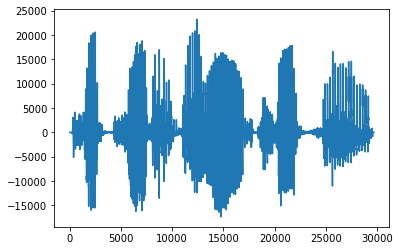

In [86]:
# data = data[250:4000]
plt.plot(data)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


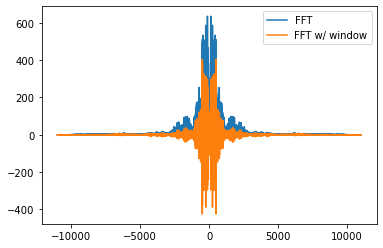

In [5]:
# Every frequency fft
N = data.shape[0]
yf = fft.fft(data)
xf = fft.fftfreq(N, 1 / samplerate)

w = blackman(N)
wyf = fft.fft(data*w)

plt.plot(xf, 2.0/N * np.abs(yf), label='FFT')
plt.plot(xf, 2.0/N * (wyf), label='FFT w/ window')
plt.legend()

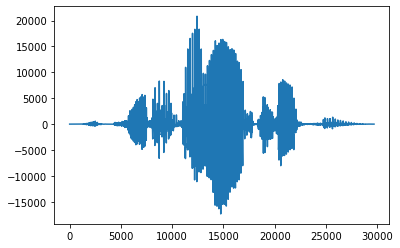

In [6]:
plt.plot(data*w)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


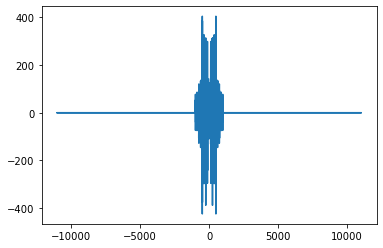

In [7]:
# Top frequency fft
N_FREQS = 1000
idx = np.argpartition(-np.abs(wyf), N_FREQS)[:N_FREQS]

fyf = np.zeros_like(wyf)
fyf[idx] = wyf[idx]
plt.plot(xf, 2.0/N * (fyf))

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


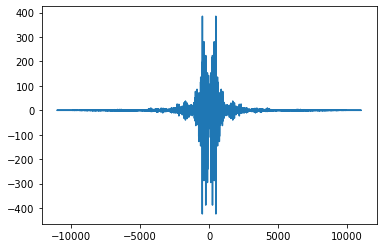

In [8]:
# Find peaks
idx, _ = find_peaks(np.abs(wyf), distance=1)

peaks_yf = np.zeros_like(wyf)
peaks_yf[idx] = wyf[idx]
plt.plot(xf, 2.0/N * (peaks_yf))

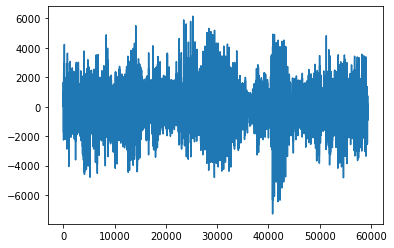

In [9]:
recover_data = fft.irfft(peaks_yf)
plt.plot(recover_data)

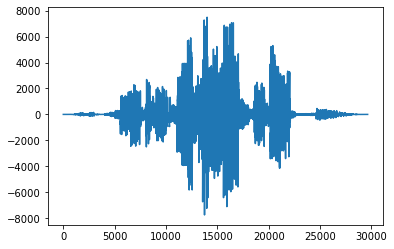

In [89]:
# Now, how Jack The Ripper would said let's go by parts
sections = np.array_split(data*w, N // 500)
recover_data = np.array([])
freqs_chords = []
for section in sections:
    n = section.shape[0]
    yf = fft.rfft(section)
    xf = fft.rfftfreq(n, 1 / samplerate)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.plot(xf, 2.0/N * np.abs(yf))

    # Find peaks method
#     idx, _ = find_peaks(np.abs(yf), distance=1)
    idx = find_peaks_cwt(np.abs(yf), 1.).astype(np.int16)
    
    # N hightest freqs method
#     N_FREQS = 25
#     idx = np.argpartition(-np.abs(yf), N_FREQS)[:N_FREQS]

    peaks_yf = np.zeros_like(yf)
    peaks_yf[idx] = yf[idx]
#     ax2.plot(xf, 2.0/N * (np.abs(peaks_yf)))
    freqs_chords.append((xf[idx], np.abs(yf[idx])))
    recover_data = np.concatenate([recover_data, fft.irfft(peaks_yf)])
plt.plot(recover_data)

In [90]:
"""
# Now let's go by parts but using scipy.signal.stft
f, t, Zxx = stft(data*w, fs=samplerate, noverlap=0, nperseg=500)
# plt.pcolormesh(t, f, np.abs(Zxx))
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()
Zxx = np.swapaxes(Zxx, 0, 1)
# plt.plot(f, Zxx[0])
# plt.show()

recover_data = np.array([])
freqs_chords = []
for section in Zxx:
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.plot(f, np.abs(section))

    # Find peaks method
    #idx, _ = find_peaks(np.abs(section), distance=1)

    # N hightest freqs method
    N_FREQS = 25
    idx = np.argpartition(-np.abs(section), N_FREQS)[:N_FREQS]

    peaks_yf = np.zeros_like(section)
    peaks_yf[idx] = section[idx]
#     ax2.plot(f, (np.abs(peaks_yf)))
    freqs_chords.append((f[idx], np.abs(section[idx])))
    recover_data = np.concatenate([recover_data, fft.irfft(peaks_yf)])
plt.plot(recover_data)
"""

"\n# Now let's go by parts but using scipy.signal.stft\nf, t, Zxx = stft(data*w, fs=samplerate, noverlap=0, nperseg=500)\n# plt.pcolormesh(t, f, np.abs(Zxx))\n# plt.title('STFT Magnitude')\n# plt.ylabel('Frequency [Hz]')\n# plt.xlabel('Time [sec]')\n# plt.show()\nZxx = np.swapaxes(Zxx, 0, 1)\n# plt.plot(f, Zxx[0])\n# plt.show()\n\nrecover_data = np.array([])\nfreqs_chords = []\nfor section in Zxx:\n#     fig, (ax1, ax2) = plt.subplots(1, 2)\n#     ax1.plot(f, np.abs(section))\n\n    # Find peaks method\n    #idx, _ = find_peaks(np.abs(section), distance=1)\n\n    # N hightest freqs method\n    N_FREQS = 25\n    idx = np.argpartition(-np.abs(section), N_FREQS)[:N_FREQS]\n\n    peaks_yf = np.zeros_like(section)\n    peaks_yf[idx] = section[idx]\n#     ax2.plot(f, (np.abs(peaks_yf)))\n    freqs_chords.append((f[idx], np.abs(section[idx])))\n    recover_data = np.concatenate([recover_data, fft.irfft(peaks_yf)])\nplt.plot(recover_data)\n"

In [91]:
wavfile.write('./recover_test.wav', samplerate, recover_data)

In [92]:
def freq2mid(freq):
    return 69 + 12*np.log2(freq / 440)

In [98]:
from mido import Message, MidiFile, MidiTrack
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
track.append(Message('program_change', program=12, time=0))
chords = [[freq2mid(chord).round().astype(np.int16), intensities] for chord, intensities in freqs_chords]

for chord in chords:
    intensities = chord[1]
#     chord[1] = intensities / intensities.max()
#     chord[1] = 2.0 / N * intensities
#     plt.bar(chord[0], chord[1])
#     plt.show()
    for note, intensity in zip(*chord):
        if intensity >= np.quantile(intensities, .9):
            track.append(Message('note_on', note=note, velocity=30, time=0))
    track.append(Message('note_on', note=note, velocity=30, time=15))
    for note, intensity in zip(*chord):
        track.append(Message('note_off', note=note, velocity=30, time=0))
    track.append(Message('note_off', note=note, velocity=30, time=15))
mid.save('new_song.mid')